## Pipelines Example Workflow

This is a minimal example which demonstrates how to list your pipelines, upload a file, start and follow a job, and do something with the results. In this instance we will do some joint angle plotting. While this is something already provided in Pipelines, it serves as a basic use case. Ensure you read carefully, as it contains some instructions for modification along the way.

Note that all of the API interaction (the actual network requests) are in `api_utils.py`, beside this file. All API endpoints can be found [here](https://api.pipelines.test.ati.ausport.gov.au/api-docs/).

### Import packages

In [1]:
import time
import os
import csv
import requests
import matplotlib.pyplot as plt
from pprint import pprint

import api_utils

### Define variables

If you don't yet have an API key, you can get one by opening a pipeline in the [Pipelines
web app](https://pipelines.ati.ausport.gov.au/) and hitting the little "profile" icon
to the top right of the screen. Then click "API Access" to generate and copy your key. Paste this key into the `api_key` variable below.

If this menu option is missing, email `AISDevelopers@ausport.gov.au` to request access.

**Your API key is private and should not be shared. You will need to generate a new key if you lose it.**

In [2]:
api_key = 'YOUR-API-KEY-HERE'
api_utils.set_api_key(api_key)

Now enter the path to the video file you'll be using.

In [3]:
video_file_path = '/PATH/TO/VIDEO/FILE/HERE.mp4'

if not os.path.exists(video_file_path):
    raise FileNotFoundError('Video not found')

### Select your pipeline

As this workflow involves fetching and plotting joint angles, you'll need to have a pipeline which does so. If you don't have one yet, visit the [Pipelines web app](https://pipelines.ati.ausport.gov.au/) and create a new pipeline from the `Joint Angle Estimation` template.

The variables below correspond to the input Video Loader node, and the field that expects to receive the video. Yours will probably be the same as below, but you can always verify this in the web app. A node ID is its name, which is editable by clicking the title of the node. The property ID is visible by hovering over the "i" icon to the right side of that input/output name.

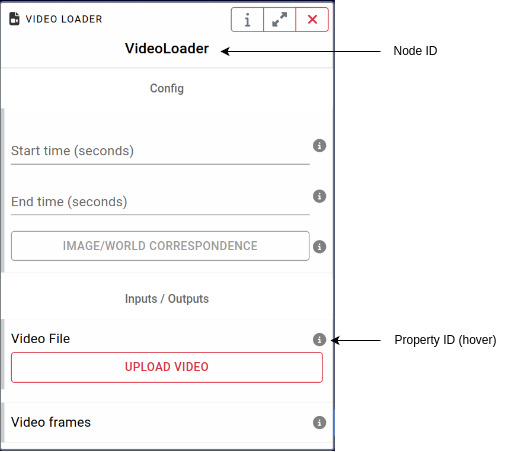

In [4]:
# You shouldn't have to modify these variables
input_node_id = 'VideoLoader'
input_property_id = 'source'
output_node_id = 'JointAngleMeasurer_joint_angles_output'

In [5]:
pipelines = api_utils.get_pipelines()

for pipeline in pipelines:
    print(f'{pipeline["id"]}: {pipeline["name"]}')

6c09fe52-15b7-46c1-97c2-11399657fdcc: World Tracking [Voronoi]
8a5ac355-6047-4ce2-b743-2cc6636b38c3: Pose
a5568119-185d-4200-ab2b-7a0b6c8dd262: Kinogram
5c6aad86-e79c-41cd-8a49-656ea25c615c: Kinovea Outputs
dc1b0344-31a5-43e7-8ab8-27fc7599b651: Joint Angle
d731bf2a-0081-4f09-8365-ffd3953919c1: Detect, Track, Pose, Angles
645dbf73-a404-4873-8cdc-591f4f2e7dbe: Stride and Angle


### Choose your pipeline

The joint angle estimation pipeline you created should be listed above - copy and paste its ID into the `pipeline_id` variable below. You can also view this in the address bar of the web app.

In [6]:
pipeline_id = 'dc1b0344-31a5-43e7-8ab8-27fc7599b651'

###  Create a new "blob" and upload the video

We use the term "blob" to refer to any pipelines file, be it video, json, csv, etc. You will need to first create a blob for your video file and receive an upload URL, then upload the video file to this URL. This is more-or-less the same as clicking the upload button via the web app.

In [7]:
# Create the blob
upload_url, blob_id = api_utils.generate_blob_upload_url_and_id(
    filename=os.path.basename(video_file_path),
    pipeline_id=pipeline_id,
    node_id=input_node_id,
    property_id=input_property_id,
    blob_type='video')

print('Blob created')

# Upload the video data
with open(video_file_path, 'rb') as f:
    api_utils.upload_file(f, upload_url, blob_id)

print('Video uploaded')

Blob created
Video uploaded


### Run and follow the job

As the job may (will) take some time to process, you will need to start it, then continuously poll the server for an updated status.

In [8]:
# Override some config - this will not be persisted on the pipeline after the job's completion (or failure)
# Note that the specific names of the node (JointAngleMeasurer) and the config properties (*_keypoint)
# can be found in the web app user interface. The node name is at the top of the node, and the config
# properties are found by hovering over the "i" icon to their right.

config = {
    'JointAngleMeasurer': {
        'from_keypoint': 'left_ankle',
        'vertex_keypoint': 'left_knee',
        'to_keypoint': 'left_hip'
    }
}

In [12]:
api_utils.start_job(pipeline_id, config_override=config)

print('Job queued...')

Job queued...


In [13]:
job_status = 'QUEUED'
while job_status in ('QUEUED', 'STARTING', 'RUNNING'):
    job_status, completion_percentage = api_utils.get_job_status_and_percentage(
        pipeline_id)
    print(f'Job {job_status.lower()} ({(completion_percentage or 0) * 100:.1f}%)', end='\r')
    time.sleep(1)
    
print(f'Job ended with status {job_status}')

Job ended with status COMPLETE


### Cancel the job (optional)

You can, if required, cancel the job. This can also be done by visiting the web app. This code is commented out by default.

In [10]:
# api_utils.cancel_job(pipeline_id)

### Fetch and plot results

After the job has finished, we need to get the download URL of the output blob, then download it from this URL. We can then do any post-processing we desire. In this case, that's just a basic time-series plot.

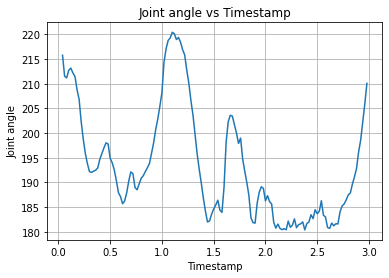

In [15]:
blobs = api_utils.get_blobs(pipeline_id)

blob = next((blob_data for blob_data in blobs if blob_data.get('nodeId') == output_node_id), None)

if not blob:
    print(f'No data found with nodeId {output_node_id}')
else:
    blob_data = requests.get(blob['downloadUrl']['url'])

    # Read CSV data and take note of column names
    reader = csv.DictReader(blob_data.text.split('\n'), lineterminator='\n')
    
    joint_angle_cols = [col for col in reader.fieldnames if \
                       'joint_angle' in col]

    # Extract the joint angle data
    x_values = []
    y_values = []
    for row in reader:
        timestamp =row['timestamp (sec)']
        rowdata = []
        for col in joint_angle_cols:
            rowdata.append(float(row[col] or 'nan'))
            
        x_values.append(float(timestamp))
        y_values.append(rowdata)

    # Plot
    plt.plot(x_values, y_values)
    plt.xlabel('Timestamp')
    plt.ylabel('Joint angle')
    plt.title('Joint angle vs Timestamp')
    plt.grid(True)
    plt.show()